--- Launch Data Loaded ---
Years: 2000 - 2025
Data points: 26
Historical launches: [(np.int64(2000), np.int64(85)), (np.int64(2001), np.int64(59)), (np.int64(2002), np.int64(65)), (np.int64(2003), np.int64(63)), (np.int64(2004), np.int64(55)), (np.int64(2005), np.int64(56)), (np.int64(2006), np.int64(66)), (np.int64(2007), np.int64(68)), (np.int64(2008), np.int64(69)), (np.int64(2009), np.int64(78)), (np.int64(2010), np.int64(74)), (np.int64(2011), np.int64(84)), (np.int64(2012), np.int64(78)), (np.int64(2013), np.int64(81)), (np.int64(2014), np.int64(92)), (np.int64(2015), np.int64(87)), (np.int64(2016), np.int64(85)), (np.int64(2017), np.int64(90)), (np.int64(2018), np.int64(114)), (np.int64(2019), np.int64(102)), (np.int64(2020), np.int64(114)), (np.int64(2021), np.int64(146)), (np.int64(2022), np.int64(186)), (np.int64(2023), np.int64(223)), (np.int64(2024), np.int64(263)), (np.int64(2025), np.int64(329))]

--- Logistic Launch Rate Curve Fit Results ---
Model: L(t) = K / (1 + A * e

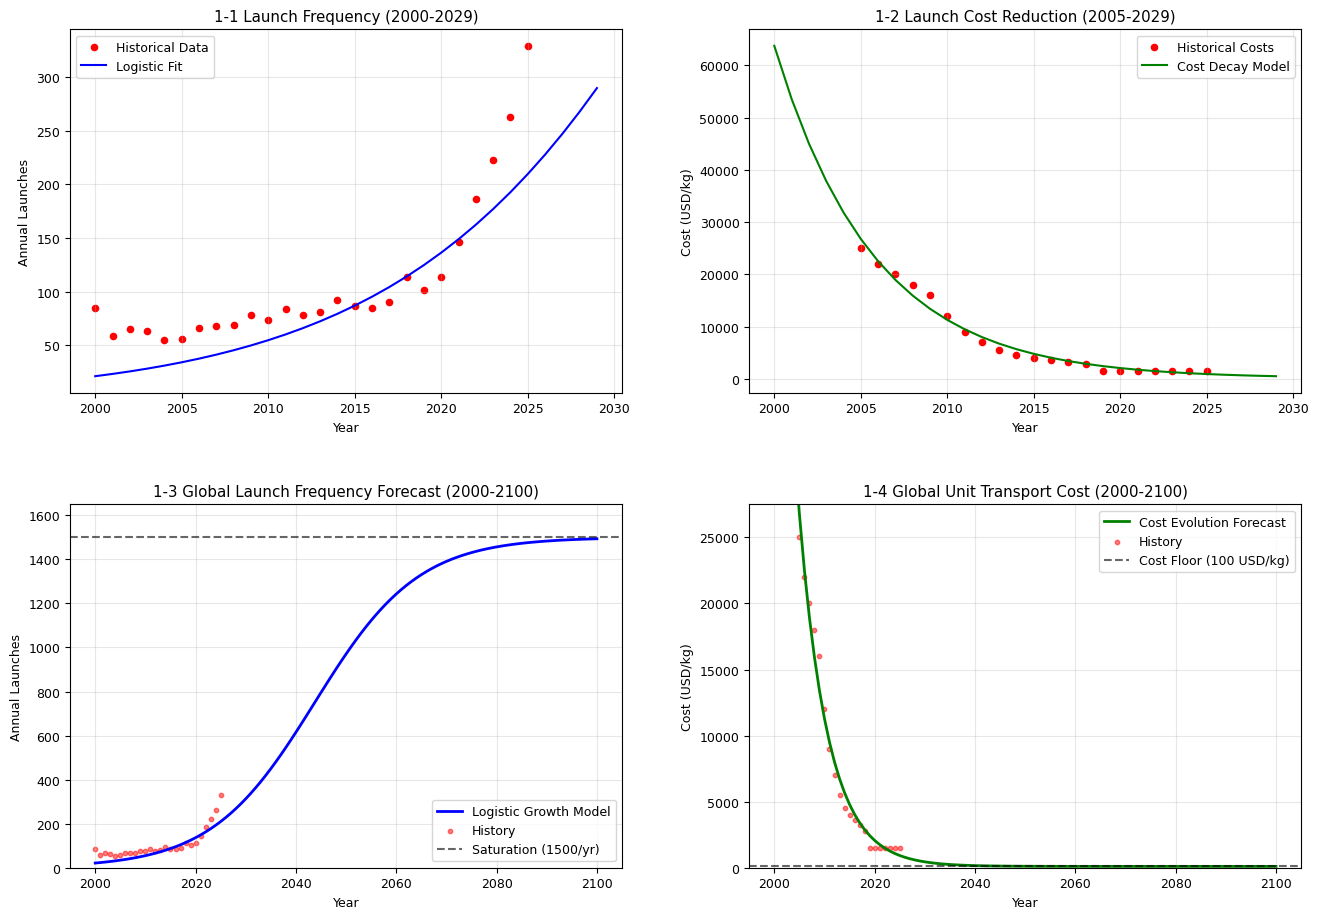

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pathlib import Path

# 设置全局字体大小，防止重叠
plt.rcParams.update({'font.size': 9})

# --- 模型定义 ---
def logistic_func(t, K, A, r, t0=2005):
    """Single logistic growth model for launch frequency."""
    return K / (1 + A * np.exp(-r * (t - t0)))

def bi_logistic_func(t, K1, r1, t1, K2, r2, t2):
    """
    Bi-Logistic (Double Logistic) Model for launch frequency.
    Captures two distinct growth phases:
    - Phase 1 (Space Race): K1, r1, t1 (inflection ~1965)
    - Phase 2 (Commercial Space): K2, r2, t2 (inflection ~2020)
    
    L(t) = K1/(1 + exp(-r1*(t-t1))) + K2/(1 + exp(-r2*(t-t2)))
    """
    wave1 = K1 / (1 + np.exp(-r1 * (t - t1)))
    wave2 = K2 / (1 + np.exp(-r2 * (t - t2)))
    return wave1 + wave2

def cost_decay_func(x, C_start, C_min, lam):
    """Exponential decay model for launch cost."""
    t0 = 2005
    return (C_start - C_min) * np.exp(-lam * (x - t0)) + C_min

# --- 1. 从 launch_data.txt 读取发射数据 ---
def load_launch_data(filepath: str) -> tuple[np.ndarray, np.ndarray]:
    """
    Parse launch_data.txt and extract year + total launches.
    Returns (years, totals) arrays.
    """
    years = []
    totals = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.split()
            if len(parts) < 3:
                continue
            # Skip header and "Total" row
            if parts[1] in ('YDate', 'Total'):
                continue
            try:
                year = int(parts[1])
                total = int(parts[-1])
                # Exclude partial years (2026 only has partial data as of Feb 2026)
                if year >= 1957 and year <= 2025:
                    years.append(year)
                    totals.append(total)
            except ValueError:
                continue
    return np.array(years), np.array(totals)

# Load data from file
data_path = 'launch_data.txt'
all_years, all_launches = load_launch_data(data_path)

# Filter to modern era (2000+) for curve fitting - remove pre-2000 data
mask = all_years >= 2000
hist_years = all_years[mask]
hist_launches = all_launches[mask]

print(f"--- Launch Data Loaded ---")
print(f"Years: {hist_years[0]} - {hist_years[-1]}")
print(f"Data points: {len(hist_years)}")
print(f"Historical launches: {list(zip(hist_years, hist_launches))}")

# Define year ranges for plotting (from 2000 to 2029/2100)
earliest_year = int(hist_years.min())  # 2000
years_short = np.arange(earliest_year, 2030)
years_full = np.arange(earliest_year, 2101)

# Historical Cost (USD/kg to LEO) - Approximate Market Rates (2005-2025)
hist_costs = [
    25000, 22000, 20000, 18000, 16000, 12000,  9000,  7000,  5500,  4500,  # 2005-2014
     4000,  3600,  3200,  2800,  1520,  1520,  1520,  1520,  1520,  1520,  # 2015-2024
     1520  # 2025
]
# Align cost data with loaded years
hist_cost_years = np.arange(2005, 2005 + len(hist_costs))

# --- 2. 拟合计算 ---
# 1-1 发射次数拟合 (Single Logistic Curve)
# L(t) = L_max / (1 + A * exp(-k * (t - t0)))
# t0 is the inflection point, k is growth rate, L_max is saturation cap

# Fix L_max at a reasonable industry projection since we're still pre-inflection
L_max_fixed = 1500  # Fixed long-term saturation (conservative estimate)

def logistic_fixed_Lmax(t, A, k, t0):
    """Single logistic curve with L_max fixed."""
    return L_max_fixed / (1 + A * np.exp(-k * (t - t0)))

# Parameters: A (initial ratio), k (growth rate), t0 (inflection year)
p0_log = [100, 0.15, 2030]
bounds_log = (
    [10, 0.05, 2020],     # lower bounds
    [1000, 0.5, 2050]     # upper bounds
)

popt_log, _ = curve_fit(
    logistic_fixed_Lmax, hist_years, hist_launches, 
    p0=p0_log, bounds=bounds_log, maxfev=10000
)
A, k, t0 = popt_log

# Generate predictions for full year ranges using the fitted model
y_freq_fit = logistic_fixed_Lmax(years_short, *popt_log)
y_launches_full = logistic_fixed_Lmax(years_full, *popt_log)

# Saturation cap
L_max = L_max_fixed

# Print launch rate prediction results
print(f"\n--- Logistic Launch Rate Curve Fit Results ---")
print(f"Model: L(t) = K / (1 + A * exp(-r * (t - t0)))")
print(f"Fitted to historical data (2000-2024)")
print(f"\n--- For constants.yaml (launch_rate section) ---")
print(f"# Logistic Growth Model: L(t) = K / (1 + A * exp(-r * (t - t0)))")
print(f"# Fitted to historical data (2000-2024)")
print(f"K: {L_max:.0f}        # Carrying capacity (max launches/year)")
print(f"A: {A:.2f}          # Initial scaling factor")
print(f"r: {k:.4f}       # Growth rate")
print(f"t0: {t0:.0f}        # Fitted inflection year")
print(f"\n--- Launch Rate Predictions Before 2100 ---")
for year in [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]:
    pred = logistic_fixed_Lmax(year, *popt_log)
    print(f"  Year {year}: {pred:.0f} launches/year")
print(f"\n*** PREDICTION CAP (Maximum Annual Launches Before 2100): {L_max:.0f} launches/year ***")

# 1-2 发射成本拟合 (2005-2029)
# C(t) = (C_start - C_min) * exp(-lam * (t - 2005)) + C_min
p0_cost = [25000, 500, 0.15]  # Start 25k, Min 500, Decay 0.15
bounds_cost = ([10000, 100, 0.05], [50000, 2000, 0.5])  # C_min >= 100 (realistic floor)

popt_cost_s, _ = curve_fit(cost_decay_func, hist_cost_years, hist_costs, p0=p0_cost, bounds=bounds_cost)
C_start_2005, C_min, lam_annual = popt_cost_s

# Calculate parameters for constants.yaml (Base Year 2050)
year_target = 2050
t_diff = year_target - 2005
C_2050 = (C_start_2005 - C_min) * np.exp(-lam_annual * t_diff) + C_min
lam_monthly = lam_annual / 12.0

print(f"\n--- Cost Decay Curve Fit Results ---")
print(f"Model: C(t) = (C_start - C_min) * exp(-lambda * t) + C_min")
print(f"Fitted to 2005-2024 history ($25k -> $1.5k)")
print(f"Fitted Parameters:")
print(f"  C_start (2005): ${C_start_2005:.2f}/kg")
print(f"  C_min (Floor):  ${C_min:.2f}/kg")
print(f"  Lambda (Annual): {lam_annual:.4f}")

print(f"\n--- For constants.yaml (cost_decay section) ---")
print(f"# Base Year t=0 is 2050.")
print(f"base_year: 2050")
print(f"base_cost_usd_per_kg: {C_2050:.2f}  # Projected cost at 2050")
print(f"decay_rate_monthly: {lam_monthly:.6f}  # Annual: {lam_annual:.4f} -> Monthly: {lam_monthly:.4f}")
print(f"min_cost_usd_per_kg: {C_min:.2f}  # Floor cost")

y_cost_s_fit = cost_decay_func(years_short, *popt_cost_s)

# 1-4 成本预测 (2005-2100) - Cost Decay (Full Range)
# Using the fitted parameters extended to 2100
y_cost_l_fit = cost_decay_func(years_full, *popt_cost_s)

# --- 3. 绘图 ---
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# [1-1] 发射次数验证 (2000-2029) - Near Term with Historical Data
axs[0, 0].scatter(hist_years, hist_launches, color='red', s=20, label='Historical Data')
axs[0, 0].plot(years_short, y_freq_fit, 'b-', label='Logistic Fit')
axs[0, 0].set_title(f'1-1 Launch Frequency ({earliest_year}-2029)')
axs[0, 0].set_ylabel('Annual Launches')
axs[0, 0].legend()
axs[0, 0].grid(True, alpha=0.3)

# [1-2] 发射成本验证 (2005-2029)
axs[0, 1].scatter(hist_cost_years, hist_costs, color='red', s=20, label='Historical Costs')
axs[0, 1].plot(years_short, y_cost_s_fit, 'g-', label='Cost Decay Model')
axs[0, 1].set_title('1-2 Launch Cost Reduction (2005-2029)')
axs[0, 1].set_ylabel('Cost (USD/kg)')
axs[0, 1].legend()
axs[0, 1].grid(True, alpha=0.3)

# [1-3] 发射次数预测 (2000-2100) - 全局 S 曲线
axs[1, 0].plot(years_full, y_launches_full, 'b-', linewidth=2, label='Logistic Growth Model')
axs[1, 0].scatter(hist_years, hist_launches, color='red', s=10, alpha=0.5, label='History')
axs[1, 0].axhline(y=L_max, color='black', linestyle='--', alpha=0.6, label=f'Saturation ({int(L_max)}/yr)')
axs[1, 0].set_title(f'1-3 Global Launch Frequency Forecast ({earliest_year}-2100)')
axs[1, 0].set_ylabel('Annual Launches')
axs[1, 0].set_ylim(0, L_max * 1.1)  # Auto-scale with 10% margin above saturation
axs[1, 0].legend(loc='lower right')
axs[1, 0].grid(True, alpha=0.3)

# [1-4] 成本预测 (2005-2100) - 全局视角
axs[1, 1].plot(years_full, y_cost_l_fit, 'g-', linewidth=2, label='Cost Evolution Forecast')
axs[1, 1].scatter(hist_cost_years, hist_costs, color='red', s=10, alpha=0.5, label='History')
axs[1, 1].axhline(y=100, color='black', linestyle='--', alpha=0.6, label='Cost Floor (100 USD/kg)')
axs[1, 1].set_title(f'1-4 Global Unit Transport Cost ({earliest_year}-2100)')
axs[1, 1].set_ylabel('Cost (USD/kg)')
# Auto-range with margin based on max historical cost
axs[1, 1].set_ylim(0, max(hist_costs) * 1.1)
axs[1, 1].legend()
axs[1, 1].grid(True, alpha=0.3)

# 统一 X 轴标签并自动优化间距
for ax in axs.flat:
    ax.set_xlabel('Year')

plt.tight_layout(pad=4.0)
plt.show()
